W1204 23:22:08.139348  389966 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1204 23:22:08.145401  389881 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


Plotting initial state...


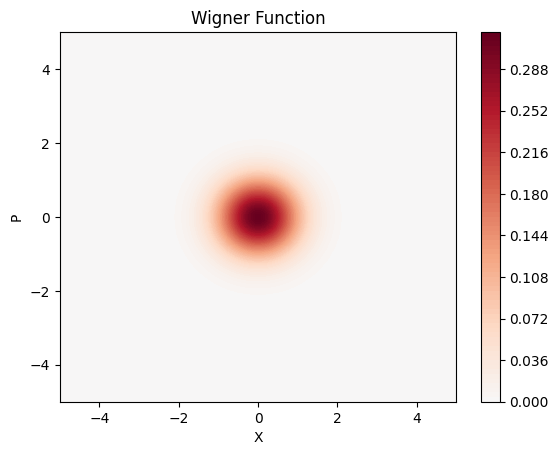

Starting integration (DOP853) from t=0.0 to 20...


KeyboardInterrupt: 

In [1]:
import jax.numpy as jnp
import jax.numpy.linalg as jla
import jax
import jax.scipy.linalg as jsl
import matplotlib.pyplot as plt
import matplotlib
from functools import partial
from typing import Union, Tuple, Iterator
import fractions
import itertools
import functools
import math
import numpy as np
from scipy.integrate import solve_ivp # Import Scipy integrator

import jax
import jax.numpy as jnp
from jax.experimental import jet

jax.config.update("jax_enable_x64", True)

Rational = Union[int, fractions.Fraction]

# --- [Existing Math Helper Functions Remain Unchanged] ---

@functools.lru_cache(maxsize=None)
def binomial_coeff(n: Rational, k: int) -> Rational:
    if k < 0:
        raise ValueError("k must be a non-negative integer")
    n = fractions.Fraction(n)
    result = 1
    for i in range(k):
        result *= (n - i) / (i + 1)
    return result

MultiIndex = Tuple[int, ...]

def multi_index_lte(i: MultiIndex) -> Iterator[MultiIndex]:
    return itertools.islice(
        itertools.product(*(range(0, k + 1) for k in i)),
        1,
        None,
    )

@functools.lru_cache(maxsize=None)
def multi_index_binomial_coeff(i: Tuple[Rational, ...],
                               j: MultiIndex) -> Rational:
    result = 1
    for i_k, j_k in zip(i, j):
        result *= binomial_coeff(i_k, j_k)
    return result

def coeffs(i: MultiIndex) -> Iterator[Tuple[MultiIndex, Rational]]:
    for j in multi_index_lte(i):
        c = multi_index_binomial_coeff(i, j) * (-1)**(sum(i) - sum(j))
        if c != 0:
            yield j, c

@functools.lru_cache(maxsize=None)
def precompute_kc(orders: MultiIndex) -> Tuple[np.ndarray, np.ndarray]:
    ks, cs = [], []
    for k, c in coeffs(orders):
        k = np.array(list(map(float, k)))
        c = float(c)
        ks.append(list(k))
        cs.append(c)
    ks = np.array(ks)
    cs = np.array(cs)
    return ks, cs

def mixed_partial(f, orders: MultiIndex):
    d = sum(orders)
    ks, cs = precompute_kc(orders)
    dfact = math.factorial(d)

    def partial_der(x0):
        @jax.vmap
        def jetter(j):
            hs = (j, ) + (jnp.zeros_like(x0), ) * (d - 1)
            _, (*_, res) = jet.jet(f, (x0, ), (hs, ),)
            return res
        return jnp.sum(jetter(ks) * cs) / dfact
    return partial_der

# --- [Physical Constants and Model Definition] ---

G = .3 + .3j
delta = .1
U = .1
gamma = 1

def calculate_covariance(covariance_params):
    x, y, phi = covariance_params
    R = jnp.array([
        [jnp.cos(phi), -jnp.sin(phi)],
        [jnp.sin(phi), jnp.cos(phi)]
    ])
    S = jnp.array([
        [jnp.exp(x), 0],
        [0, jnp.exp(y)]
    ])
    Sigma = R@S@S@R.T
    return Sigma

def unwrap_params(params):
    normalization = params[0]
    mean = params[1:5]
    covariance_params = params[5:8]
    return normalization, mean, covariance_params

def generating_function(params_a, params_b, Js):
    normalization_a, mean_a, covariance_params_a = unwrap_params(params_a)
    normalization_b, mean_b, covariance_params_b = unwrap_params(params_b)
    alpha_a, beta_a = mean_a[::2], mean_a[1::2]
    alpha_b, beta_b =  mean_b[::2], mean_b[1::2]
    J, J_tilde = Js[:Js.size//2], Js[Js.size//2:]
    
    M_modes = 1
    covariance_a = calculate_covariance(covariance_params_a)
    covariance_b = calculate_covariance(covariance_params_b)
    
    covariance_sum = covariance_a + covariance_b
    covariance_sum_inv = jla.inv(covariance_sum)
    
    v1 = alpha_b - alpha_a - jnp.dot(covariance_a, J) - J_tilde
    inv_sigma_sum_v1 = jnp.dot(covariance_sum_inv, v1)
    
    diff_beta = beta_b - beta_a
    sum_beta = beta_b + beta_a
    inv_sigma_sum_diff_beta = jnp.dot(covariance_sum_inv, diff_beta)
    inv_sigma_sum_sum_beta = jnp.dot(covariance_sum_inv, sum_beta)

    Z1 = jnp.exp(-0.5 * jnp.dot(v1, inv_sigma_sum_v1))
    M_minus = jnp.exp(0.5 * jnp.dot(diff_beta, inv_sigma_sum_diff_beta))
    M_plus = jnp.exp(0.5 * jnp.dot(sum_beta, inv_sigma_sum_sum_beta))
    
    J_dot_beta = jnp.dot(J, beta_a)
    mix_term_minus = jnp.dot(diff_beta, inv_sigma_sum_v1)
    mix_term_plus = jnp.dot(sum_beta, inv_sigma_sum_v1)
    
    C_minus = jnp.cos(J_dot_beta - mix_term_minus)
    C_plus = jnp.cos(J_dot_beta + mix_term_plus)
    num_exponent = 0.5 * jnp.dot(J, jnp.dot(covariance_a, J)) + jnp.dot(J, alpha_a)
    
    sign, logdet = jnp.linalg.slogdet(covariance_sum)
    log_denominator = 0.5 * (2*M_modes * jnp.log(2 * jnp.pi) + logdet)
    prefactor = 0.5 * jnp.exp(num_exponent - log_denominator)
    
    return normalization_a*normalization_b*prefactor * Z1 * (M_minus * C_minus + M_plus * C_plus)

@jax.jit
def geometric_tensor(params):
    def total_gen_func(params_a, params_b):
        params_a = params_a.at[:,0].set(params_a[:,0]**2/jnp.sum(params_a[:,0]**2))
        params_b = params_b.at[:,0].set(params_b[:,0]**2/jnp.sum(params_b[:,0]**2))
        return jnp.sum(jax.vmap(lambda param_a: jax.vmap(lambda param_b: generating_function(param_a, param_b, jnp.zeros((4))))(params_a))(params_b))
    return jax.jacfwd(jax.grad(total_gen_func, argnums=(1)), argnums=(0))(params, params).reshape(params.size, params.size)

def g(param_a, param_b, orders):
    if sum(orders) == 0:
        return generating_function(param_a, param_b, jnp.zeros((4)))
    g_f = partial(generating_function, param_a, param_b)
    return mixed_partial(g_f, orders)(jnp.zeros((4)))

def g_term(param_a, param_b):
    real_term = jnp.real(G)*(g(param_a, param_b,(0,1,1,0))+g(param_a, param_b,(1,0,0,1)))
    imag_term = jnp.imag(G)*(g(param_a, param_b,(1,0,1,0))-g(param_a, param_b,(0,1,0,1)))
    return real_term - imag_term

def delta_term(param_a, param_b):
    return delta*(g(param_a, param_b,(0,1,1,0))-g(param_a, param_b,(1,0,0,1)))

def u_term(param_a, param_b):
    total = g(param_a, param_b, (3,0,0,1)) 
    total += g(param_a, param_b, (1,2,0,1)) 
    total += -g(param_a, param_b, (2,1,1,0))
    total += -g(param_a, param_b, (0,3,1,0))
    total += 2*g(param_a, param_b, (0,1,1,0))
    total += -2*g(param_a, param_b, (1,0,0,1))
    total += 0.25*g(param_a, param_b, (0,1,3,0))
    total += -0.25*g(param_a, param_b, (1,0,0,3))
    total += -0.25*g(param_a, param_b, (1,0,2,1))
    total += 0.25*g(param_a, param_b, (0,1,1,2))
    return U/2*total

def single_photon_loss_term(param_a, param_b):
    total = g(param_a, param_b, (1, 0, 1, 0))
    total += g(param_a, param_b, (0, 1, 0, 1))
    total += 2*g(param_a, param_b, (0, 0, 0, 0))
    total += 0.5*g(param_a, param_b, (0,0,2,0))
    total += 0.5*g(param_a, param_b, (0,0,0,2))
    return gamma/2*total

def all_terms(params_a, params_b):
    params_a = params_a.at[:,0].set(params_a[:,0]**2/jnp.sum(params_a[:,0]**2))
    params_b = params_b.at[:,0].set(params_b[:,0]**2/jnp.sum(params_b[:,0]**2))
    def func(param_a, param_b):
        return g_term(param_a, param_b) + delta_term(param_a, param_b) + u_term(param_a, param_b) + single_photon_loss_term(param_a, param_b)
    return jnp.sum(jax.vmap(lambda param_a: jax.vmap(lambda param_b: func(param_a, param_b))(params_b))(params_a))

@jax.jit
def liouvillian_gradient(params):
    return jax.grad(all_terms, argnums=0) (params, params)

@jax.jit
def number_operator(params):
    params = params.at[:,0].set(params[:,0]**2/jnp.sum(params[:,0]**2))

    # Vectorized helper for number operator within vmap
    def single_param_n(p):
        normalization, mean, covariance_params = unwrap_params(p)
        covariance = calculate_covariance(covariance_params)
        mean = mean[::2]+ 1j* mean[1::2]
        return normalization*(jnp.sum(jnp.abs(mean)**2)+covariance[0,0]+covariance[1,1]-1)/2
    
    return jnp.sum(jax.vmap(single_param_n)(params))

@jax.jit
def parity_operator(params):
    # Vectorized helper for parity operator within vmap
    params = params.at[:,0].set(params[:,0]**2/jnp.sum(params[:,0]**2))
    def single_param_parity(p):
        normalization, mean, covariance_params = unwrap_params(p)
        covariance = calculate_covariance(covariance_params)
        mean = mean[::2]+ 1j* mean[1::2] # Used in original, but math below uses real vector mean
        # Note: Original code had -mean. 
        # exp(-0.5 * (-mean) @ inv(cov) @ (-mean)) is same as exp(-0.5 * mean @ inv(cov) @ mean)
        term = jnp.exp(-0.5 * jnp.dot(-mean, jnp.dot(jla.inv(covariance), -mean)))
        return jnp.pi * normalization * jnp.real(term) / jnp.sqrt((2*jnp.pi)**2 * jnp.linalg.det(covariance))

    return jnp.sum(jax.vmap(single_param_parity)(params))

def plot_wigner(params):
    x = jnp.linspace(-5, 5, 100)
    p = jnp.linspace(-5, 5, 100)
    X, P = jnp.meshgrid(x, p)
    W = jnp.zeros(X.shape)
    
    # We can keep the loop here as visualization is not the bottleneck
    # or vectorize it if needed, but loop is fine for plotting at start/end
    for param in params:
        normalization, mean, covariance_params = unwrap_params(param)
        covariance = calculate_covariance(covariance_params)
        det_cov = jla.det(covariance)
        inv_cov = jla.inv(covariance)
        phase_vars = jnp.array([X.flatten(), P.flatten()]).T
        mean = mean[::2]+ 1j* mean[1::2]
        diff = phase_vars - mean
        exponent = -0.5 * jnp.einsum("ij,ij->i", jnp.dot(diff, inv_cov), diff)
        exponent = exponent.reshape(X.shape)
        W += normalization/(2*jnp.pi*jnp.sqrt(det_cov)) * jnp.real(jnp.exp(exponent))
        
    norm = matplotlib.colors.Normalize(-abs(W).max(), abs(W).max())
    plt.figure()
    plt.contourf(X, P, W, levels=100, cmap='RdBu_r', norm=norm)
    plt.colorbar()
    plt.xlabel('X')
    plt.ylabel('P')
    plt.title('Wigner Function')
    plt.show()

# --- [Initialization Functions] ---

def initialize_cat_state(alpha=1.0):
    N_G = 4
    params = jnp.zeros((N_G, 8))
    weights = jnp.ones(N_G) 
    params = params.at[:, 0].set(weights)
    params = params.at[2:, 0].set(jnp.exp(-2 * (alpha)**2))
    
    vacuum_log_var = 0.5*jnp.log(0.5)
    params = params.at[:, 5:7].set(vacuum_log_var)
    params = params.at[:, 7].set(0.0)
    
    dist = jnp.sqrt(2) * alpha
    params = params.at[0, 1].set(dist)
    params = params.at[1, 1].set(-dist)
    params = params.at[2, 4].set(dist)
    params = params.at[3, 4].set(-dist)
    params = params.at[:,0].divide(jnp.sum(params[:,0]))
    return params

def initialize_vacuum_state(N_G):
    params = jnp.zeros((N_G, 8))
    params = params.at[:, 0].set(1.0)
    params = params.at[:,0].divide(jnp.sum(params[:,0]))
    vacuum_log_var = 0.5*jnp.log(0.5)
    params = params.at[:, 5:7].set(vacuum_log_var)
    params = params.at[:, 7].set(0.0)
    return params

def expand_state_cluster(params, expansion_factor=4, noise_scale=1e-4, key=None):
    if key is None:
        key = jax.random.PRNGKey(0)
    old_N = params.shape[0]
    new_N = old_N * expansion_factor
    new_params = jnp.zeros((new_N, 8))
    print(f"Expanding ansatz from {old_N} to {new_N} Gaussians...")
    for i in range(old_N):
        base_weight = params[i, 0]
        base_center = params[i, 1:5] # Fixed slicing index from original code
        base_cov = params[i, 5:8]
        key, subkey = jax.random.split(key)
        offsets = jax.random.normal(subkey, (expansion_factor, 4)) * noise_scale # Offset for 4 center coords
        start_idx = i * expansion_factor
        end_idx = start_idx + expansion_factor
        new_weights = (base_weight / expansion_factor) * jnp.ones(expansion_factor)
        weight_jitter = 1.0 
        new_params = new_params.at[start_idx:end_idx, 0].set(new_weights * weight_jitter)
        new_centers = base_center + offsets
        new_params = new_params.at[start_idx:end_idx, 1:5].set(new_centers)
        new_params = new_params.at[start_idx:end_idx, 5:8].set(base_cov)
    total_weight = jnp.sum(new_params[:, 0])
    new_params = new_params.at[:, 0].divide(total_weight)
    return new_params

# --- [Scipy Integration Implementation] ---

@jax.jit
def compute_update_step(params_flat):
    """
    Computes T^-1 * V efficiently using JIT.
    """
    params = params_flat.reshape((-1,8))
    
    # Calculate Gradient and Geometric Tensor
    V = liouvillian_gradient(params).flatten()
    T = geometric_tensor(params)
    
    # Regularization
    reg_strength = 1e-11
    reg = reg_strength * jnp.eye(T.shape[0])
    
    # Solve linear system
    d_params = jla.solve(T + reg, V)
    return d_params

def time_evolve(inital_time, end_time):
    # 1. Initialize State
    params = initialize_vacuum_state(6)
    #params = expand_state_cluster(params, expansion_factor=12, noise_scale=1e-7)
    param_shape = params.shape
    
    # Initial Plot
    print("Plotting initial state...")
    plot_wigner(params)
    
    # 2. Define ODE function for Scipy
    # Scipy expects f(t, y) -> dy/dt (numpy arrays)
    def ode_func(t, y):
        # Transfer numpy -> jax
        y_jax = jnp.array(y)
        # Compute derivative (JIT compiled internally)
        dydt_jax = compute_update_step(y_jax)
        # Transfer jax -> numpy
        return np.array(dydt_jax)

    # 3. Setup Integration
    y0 = np.array(params.flatten())
    t_span = (inital_time, end_time)
    t_eval = np.arange(inital_time, end_time, 1e-2)
    
    print(f"Starting integration (DOP853) from t={inital_time} to {end_time}...")
    
    # 4. Run Scipy Solver
    sol = solve_ivp(
        ode_func, 
        t_span, 
        y0, 
        method='DOP853', 
        t_eval=t_eval,
        rtol=1e-4, 
        atol=1e-6 
    )
    
    if not sol.success:
        print(f"Integration failed: {sol.message}")
        
    print("Integration complete. Computing observables...")

    # 5. Post-process Observables using JAX Vmap (Much faster than looping)
    # sol.y shape is (num_params, num_timesteps). Transpose to (num_timesteps, num_params)
    time_evolution_flat = jnp.array(sol.y.T)
    # Reshape to (num_timesteps, N_G, 8)
    time_evolution_params = time_evolution_flat.reshape(-1, *param_shape)
    
    # Vectorize observable functions over the time axis
    compute_all_n = jax.vmap(number_operator)
    compute_all_parity = jax.vmap(parity_operator)
    
    ns = compute_all_n(time_evolution_params)
    parities = compute_all_parity(time_evolution_params)
    
    # 6. Final Plot and Analysis
    final_params = time_evolution_params[-1]
    plot_wigner(final_params)
    print("Final Params:\n", final_params)

    # Plot Observables
    plt.figure()
    plt.plot(sol.t, ns, label='Number Operator')
    plt.plot(tlist, means_n, '--') 
    plt.xlabel('Time')
    plt.ylabel('<n>')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(sol.t, parities, label='Parity')
    plt.plot(tlist, means_parity, '--')
    plt.xlabel('Time')
    plt.ylabel('Parity')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the simulation
time_evolve(0.0, 20)

Expanding ansatz from 1 to 24 Gaussians...
Plotting initial state...


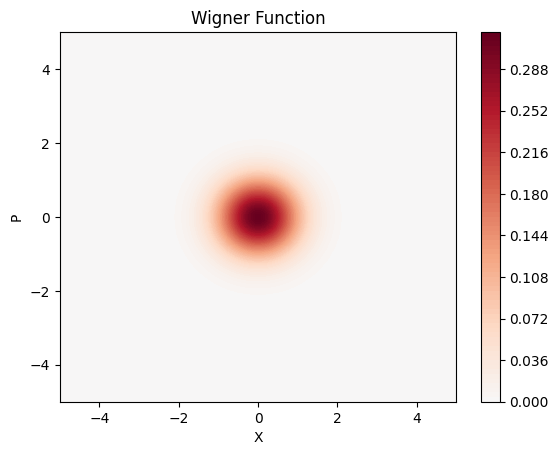

Starting integration from t=0.0 to 20...
0.00%
2.01%
4.01%


In [6]:
import jax.numpy as jnp
import jax.numpy.linalg as jla
import jax
import jax.scipy.linalg as jsl
import matplotlib.pyplot as plt
import matplotlib
from functools import partial
from typing import Union, Tuple, Iterator
import fractions
import itertools
import functools
import math
import numpy as np
from scipy.integrate import solve_ivp # Import Scipy integrator
from diffrax import diffeqsolve, Dopri8, Tsit5, ODETerm, SaveAt, PIDController
import diffrax

import jax
import jax.numpy as jnp
from jax.experimental import jet

jax.config.update("jax_enable_x64", True)

Rational = Union[int, fractions.Fraction]

# --- [Existing Math Helper Functions Remain Unchanged] ---

@functools.lru_cache(maxsize=None)
def binomial_coeff(n: Rational, k: int) -> Rational:
    if k < 0:
        raise ValueError("k must be a non-negative integer")
    n = fractions.Fraction(n)
    result = 1
    for i in range(k):
        result *= (n - i) / (i + 1)
    return result

MultiIndex = Tuple[int, ...]

def multi_index_lte(i: MultiIndex) -> Iterator[MultiIndex]:
    return itertools.islice(
        itertools.product(*(range(0, k + 1) for k in i)),
        1,
        None,
    )

@functools.lru_cache(maxsize=None)
def multi_index_binomial_coeff(i: Tuple[Rational, ...],
                               j: MultiIndex) -> Rational:
    result = 1
    for i_k, j_k in zip(i, j):
        result *= binomial_coeff(i_k, j_k)
    return result

def coeffs(i: MultiIndex) -> Iterator[Tuple[MultiIndex, Rational]]:
    for j in multi_index_lte(i):
        c = multi_index_binomial_coeff(i, j) * (-1)**(sum(i) - sum(j))
        if c != 0:
            yield j, c

@functools.lru_cache(maxsize=None)
def precompute_kc(orders: MultiIndex) -> Tuple[np.ndarray, np.ndarray]:
    ks, cs = [], []
    for k, c in coeffs(orders):
        k = np.array(list(map(float, k)))
        c = float(c)
        ks.append(list(k))
        cs.append(c)
    ks = np.array(ks)
    cs = np.array(cs)
    return ks, cs

def mixed_partial(f, orders: MultiIndex):
    d = sum(orders)
    ks, cs = precompute_kc(orders)
    dfact = math.factorial(d)

    def partial_der(x0):
        @jax.vmap
        def jetter(j):
            hs = (j, ) + (jnp.zeros_like(x0), ) * (d - 1)
            _, (*_, res) = jet.jet(f, (x0, ), (hs, ),)
            return res
        return jnp.sum(jetter(ks) * cs) / dfact
    return partial_der

# --- [Physical Constants and Model Definition] ---

G = .3 + .3j
delta = .1
U = .1
gamma = 1

def calculate_covariance(covariance_params):
    r, phi = covariance_params
    S = jnp.array([
        [jnp.cos(phi), jnp.sin(phi)],
        [jnp.sin(phi), -jnp.cos(phi)]
    ])
    Sigma = 0.5*jnp.cosh(2*r)*jnp.identity(2)-0.5*jnp.sinh(2*r)*S
    return Sigma

def unwrap_params(params):
    normalization = params[0]
    mean = params[1:5]
    covariance_params = params[5:8]
    return normalization, mean, covariance_params

def generating_function(params_a, params_b, Js):
    normalization_a, mean_a, covariance_params_a = unwrap_params(params_a)
    normalization_b, mean_b, covariance_params_b = unwrap_params(params_b)
    alpha_a, beta_a = mean_a[::2], mean_a[1::2]
    alpha_b, beta_b =  mean_b[::2], mean_b[1::2]
    J, J_tilde = Js[:Js.size//2], Js[Js.size//2:]
    
    M_modes = 1
    covariance_a = calculate_covariance(covariance_params_a)
    covariance_b = calculate_covariance(covariance_params_b)
    
    covariance_sum = covariance_a + covariance_b
    covariance_sum_inv = jla.inv(covariance_sum)
    
    v1 = alpha_b - alpha_a - jnp.dot(covariance_a, J) - J_tilde
    inv_sigma_sum_v1 = jnp.dot(covariance_sum_inv, v1)
    
    diff_beta = beta_b - beta_a
    sum_beta = beta_b + beta_a
    inv_sigma_sum_diff_beta = jnp.dot(covariance_sum_inv, diff_beta)
    inv_sigma_sum_sum_beta = jnp.dot(covariance_sum_inv, sum_beta)

    Z1 = jnp.exp(-0.5 * jnp.dot(v1, inv_sigma_sum_v1))
    M_minus = jnp.exp(0.5 * jnp.dot(diff_beta, inv_sigma_sum_diff_beta))
    M_plus = jnp.exp(0.5 * jnp.dot(sum_beta, inv_sigma_sum_sum_beta))
    
    J_dot_beta = jnp.dot(J, beta_a)
    mix_term_minus = jnp.dot(diff_beta, inv_sigma_sum_v1)
    mix_term_plus = jnp.dot(sum_beta, inv_sigma_sum_v1)
    
    C_minus = jnp.cos(J_dot_beta - mix_term_minus)
    C_plus = jnp.cos(J_dot_beta + mix_term_plus)
    num_exponent = 0.5 * jnp.dot(J, jnp.dot(covariance_a, J)) + jnp.dot(J, alpha_a)
    
    sign, logdet = jnp.linalg.slogdet(covariance_sum)
    log_denominator = 0.5 * (2*M_modes * jnp.log(2 * jnp.pi) + logdet)
    prefactor = 0.5 * jnp.exp(num_exponent - log_denominator)
    
    return normalization_a*normalization_b*prefactor * Z1 * (M_minus * C_minus + M_plus * C_plus)

@jax.jit
def geometric_tensor(params):
    def total_gen_func(params_a, params_b):
        params_a = params_a.at[:,0].set(params_a[:,0]**2/jnp.sum(params_a[:,0]**2))
        params_b = params_b.at[:,0].set(params_b[:,0]**2/jnp.sum(params_b[:,0]**2))
        return jnp.sum(jax.vmap(lambda param_a: jax.vmap(lambda param_b: generating_function(param_a, param_b, jnp.zeros((4))))(params_a))(params_b))
    return jax.jacfwd(jax.grad(total_gen_func, argnums=(1)), argnums=(0))(params, params).reshape(params.size, params.size)

def g(param_a, param_b, orders):
    if sum(orders) == 0:
        return generating_function(param_a, param_b, jnp.zeros((4)))
    g_f = partial(generating_function, param_a, param_b)
    return mixed_partial(g_f, orders)(jnp.zeros((4)))

def g_term(param_a, param_b):
    real_term = jnp.real(G)*(g(param_a, param_b,(0,1,1,0))+g(param_a, param_b,(1,0,0,1)))
    imag_term = jnp.imag(G)*(g(param_a, param_b,(1,0,1,0))-g(param_a, param_b,(0,1,0,1)))
    return real_term - imag_term

def delta_term(param_a, param_b):
    return delta*(g(param_a, param_b,(0,1,1,0))-g(param_a, param_b,(1,0,0,1)))

def u_term(param_a, param_b):
    total = g(param_a, param_b, (3,0,0,1)) 
    total += g(param_a, param_b, (1,2,0,1)) 
    total += -g(param_a, param_b, (2,1,1,0))
    total += -g(param_a, param_b, (0,3,1,0))
    total += 2*g(param_a, param_b, (0,1,1,0))
    total += -2*g(param_a, param_b, (1,0,0,1))
    total += 0.25*g(param_a, param_b, (0,1,3,0))
    total += -0.25*g(param_a, param_b, (1,0,0,3))
    total += -0.25*g(param_a, param_b, (1,0,2,1))
    total += 0.25*g(param_a, param_b, (0,1,1,2))
    return U/2*total

def single_photon_loss_term(param_a, param_b):
    total = g(param_a, param_b, (1, 0, 1, 0))
    total += g(param_a, param_b, (0, 1, 0, 1))
    total += 2*g(param_a, param_b, (0, 0, 0, 0))
    total += 0.5*g(param_a, param_b, (0,0,2,0))
    total += 0.5*g(param_a, param_b, (0,0,0,2))
    return gamma/2*total

def all_terms(params_a, params_b):
    params_a = params_a.at[:,0].set(params_a[:,0]**2/jnp.sum(params_a[:,0]**2))
    params_b = params_b.at[:,0].set(params_b[:,0]**2/jnp.sum(params_b[:,0]**2))
    def func(param_a, param_b):
        return g_term(param_a, param_b) + delta_term(param_a, param_b) + u_term(param_a, param_b) + single_photon_loss_term(param_a, param_b)
    return jnp.sum(jax.vmap(lambda param_a: jax.vmap(lambda param_b: func(param_a, param_b))(params_b))(params_a))

@jax.jit
def liouvillian_gradient(params):
    return jax.grad(all_terms, argnums=0) (params, params)

@jax.jit
def number_operator(params):
    params = params.at[:,0].set(params[:,0]**2/jnp.sum(params[:,0]**2))

    # Vectorized helper for number operator within vmap
    def single_param_n(p):
        normalization, mean, covariance_params = unwrap_params(p)
        covariance = calculate_covariance(covariance_params)
        mean = mean[::2]+ 1j* mean[1::2]
        return normalization*(jnp.sum(jnp.abs(mean)**2)+covariance[0,0]+covariance[1,1]-1)/2
    
    return jnp.sum(jax.vmap(single_param_n)(params))

@jax.jit
def parity_operator(params):
    # Vectorized helper for parity operator within vmap
    params = params.at[:,0].set(params[:,0]**2/jnp.sum(params[:,0]**2))
    def single_param_parity(p):
        normalization, mean, covariance_params = unwrap_params(p)
        covariance = calculate_covariance(covariance_params)
        mean = mean[::2]+ 1j* mean[1::2] # Used in original, but math below uses real vector mean
        # Note: Original code had -mean. 
        # exp(-0.5 * (-mean) @ inv(cov) @ (-mean)) is same as exp(-0.5 * mean @ inv(cov) @ mean)
        term = jnp.exp(-0.5 * jnp.dot(-mean, jnp.dot(jla.inv(covariance), -mean)))
        return jnp.pi * normalization * jnp.real(term) / jnp.sqrt((2*jnp.pi)**2 * jnp.linalg.det(covariance))

    return jnp.sum(jax.vmap(single_param_parity)(params))

def plot_wigner(params):
    x = jnp.linspace(-5, 5, 100)
    p = jnp.linspace(-5, 5, 100)
    X, P = jnp.meshgrid(x, p)
    W = jnp.zeros(X.shape)
    
    # We can keep the loop here as visualization is not the bottleneck
    # or vectorize it if needed, but loop is fine for plotting at start/end
    for param in params:
        normalization, mean, covariance_params = unwrap_params(param)
        covariance = calculate_covariance(covariance_params)
        det_cov = jla.det(covariance)
        inv_cov = jla.inv(covariance)
        phase_vars = jnp.array([X.flatten(), P.flatten()]).T
        mean = mean[::2]+ 1j* mean[1::2]
        diff = phase_vars - mean
        exponent = -0.5 * jnp.einsum("ij,ij->i", jnp.dot(diff, inv_cov), diff)
        exponent = exponent.reshape(X.shape)
        W += normalization/(2*jnp.pi*jnp.sqrt(det_cov)) * jnp.real(jnp.exp(exponent))
        
    norm = matplotlib.colors.Normalize(-abs(W).max(), abs(W).max())
    plt.figure()
    plt.contourf(X, P, W, levels=100, cmap='RdBu_r', norm=norm)
    plt.colorbar()
    plt.xlabel('X')
    plt.ylabel('P')
    plt.title('Wigner Function')
    plt.show()

# --- [Initialization Functions] ---

def initialize_cat_state(alpha=1.0):
    N_G = 4
    params = jnp.zeros((N_G, 8))
    weights = jnp.ones(N_G) 
    params = params.at[:, 0].set(weights)
    params = params.at[2:, 0].set(jnp.exp(-2 * (alpha)**2))
    
    vacuum_log_var = 0.5*jnp.log(0.5)
    params = params.at[:, 5:7].set(vacuum_log_var)
    params = params.at[:, 7].set(0.0)
    
    dist = jnp.sqrt(2) * alpha
    params = params.at[0, 1].set(dist)
    params = params.at[1, 1].set(-dist)
    params = params.at[2, 4].set(dist)
    params = params.at[3, 4].set(-dist)
    params = params.at[:,0].divide(jnp.sum(params[:,0]))
    return params

def initialize_vacuum_state(N_G):
    params = jnp.zeros((N_G, 8))
    params = params.at[:, 0].set(1.0)
    params = params.at[:,0].divide(jnp.sum(params[:,0]))
    vacuum_log_var = 0.5*jnp.log(0.5)
    params = params.at[:, 5:7].set(vacuum_log_var)
    params = params.at[:, 7].set(0.0)
    return params

def expand_state_cluster(params, expansion_factor=4, noise_scale=1e-4, key=None):
    if key is None:
        key = jax.random.PRNGKey(0)
    old_N = params.shape[0]
    new_N = old_N * expansion_factor
    new_params = jnp.zeros((new_N, 8))
    print(f"Expanding ansatz from {old_N} to {new_N} Gaussians...")
    for i in range(old_N):
        base_weight = params[i, 0]
        base_center = params[i, 1:5:2] # Fixed slicing index from original code
        base_cov = params[i, 5:8]
        key, subkey = jax.random.split(key)
        offsets = jax.random.normal(subkey, (expansion_factor, 2)) * noise_scale # Offset for 4 center coords
        start_idx = i * expansion_factor
        end_idx = start_idx + expansion_factor
        new_weights = (base_weight / expansion_factor) * jnp.ones(expansion_factor)
        weight_jitter = 1.0 
        new_params = new_params.at[start_idx:end_idx, 0].set(new_weights * weight_jitter)
        new_centers = base_center + offsets
        new_params = new_params.at[start_idx:end_idx, 1:5:2].set(new_centers)
        new_params = new_params.at[start_idx:end_idx, 5:8].set(base_cov)
    total_weight = jnp.sum(new_params[:, 0])
    new_params = new_params.at[:, 0].divide(total_weight)
    return new_params

# --- [Scipy Integration Implementation] ---

@jax.jit
def compute_update_step(t, params_flat, args):
    """
    Computes T^-1 * V efficiently using JIT.
    """
    params = params_flat.reshape((-1,8))
    
    # Calculate Gradient and Geometric Tensor
    V = liouvillian_gradient(params).flatten()
    T = geometric_tensor(params)
    
    # Regularization
    reg_strength = 1e-10
    reg = reg_strength * jnp.eye(T.shape[0])
    
    # Solve linear system
    d_params = jla.solve(T + reg, V)
    return d_params.flatten()

def time_evolve(initial_time, end_time):
    # 1. Initialize State
    params = initialize_vacuum_state(1)
    params = expand_state_cluster(params, expansion_factor=24, noise_scale=1e-5)
    param_shape = params.shape
    
    # Initial Plot
    print("Plotting initial state...")
    plot_wigner(params)


    # 3. Setup Integration
    t_eval = jnp.arange(initial_time, end_time, 1e-2)
    
    print(f"Starting integration from t={initial_time} to {end_time}...")
    term = ODETerm(compute_update_step)
    solver = Tsit5()
    saveat = SaveAt(ts=t_eval)
    stepsize_controller = PIDController(rtol=1e-4, atol=1e-6)

    progress_meter = diffrax.TextProgressMeter()
    sol = diffeqsolve(term, solver, t0=initial_time, t1=end_time, dt0=None, y0=params.flatten(), saveat=saveat,
                    stepsize_controller=stepsize_controller, max_steps=None, progress_meter=progress_meter)
        
    print("Integration complete. Computing observables...")
    print(sol.stats)

    # 5. Post-process Observables using JAX Vmap (Much faster than looping)
    # sol.y shape is (num_params, num_timesteps). Transpose to (num_timesteps, num_params)
    time_evolution_flat = sol.ys
    # Reshape to (num_timesteps, N_G, 8)
    time_evolution_params = time_evolution_flat.reshape(-1, *param_shape)
    
    # Vectorize observable functions over the time axis
    compute_all_n = jax.vmap(number_operator)
    compute_all_parity = jax.vmap(parity_operator)
    
    ns = compute_all_n(time_evolution_params)
    parities = compute_all_parity(time_evolution_params)

    print("Initial:", ns[0], parities[0])
    
    # 6. Final Plot and Analysis
    final_params = time_evolution_params[-1]
    plot_wigner(final_params)
    print("Final Time:", t_eval[-1])
    print("Final Params:\n", final_params)
    print("Final Number Operator:", ns[-1])
    print("Final Parity Operator:", parities[-1])

    # Plot Observables
    plt.figure()
    plt.plot(t_eval, ns, label='Number Operator')
    plt.plot(tlist, means_n, '--') 
    plt.xlabel('Time')
    plt.ylabel('<n>')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(t_eval, parities, label='Parity')
    plt.plot(tlist, means_parity, '--')
    plt.xlabel('Time')
    plt.ylabel('Parity')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(t_eval[-1], ns[-1], parities[-1])

# Run the simulation
time_evolve(0.0, 20)

[[1.]]


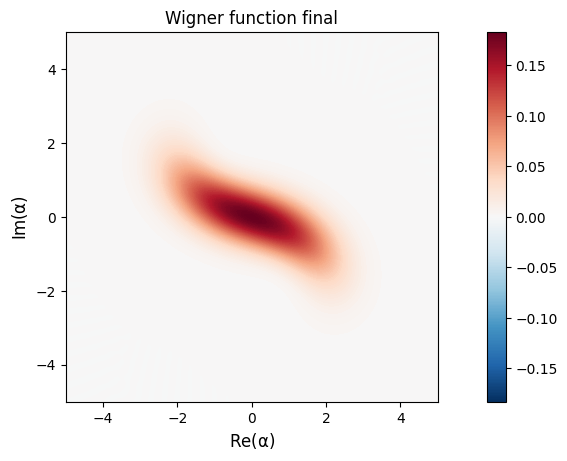

Time     | <X>        | <P>        | <n>        | <Parity>  
-----------------------------------------------------------------
0.0000   | 0.000000   | 0.000000   | 0.000000   | 1.000000
0.2020   | 0.000000   | 0.000000   | 0.006443   | 0.999190
0.4040   | 0.000000   | 0.000000   | 0.022756   | 0.994684
0.6061   | 0.000000   | 0.000000   | 0.045499   | 0.985295
0.8081   | 0.000000   | 0.000000   | 0.072309   | 0.971441
1.0101   | 0.000000   | 0.000000   | 0.101565   | 0.954250
1.2121   | 0.000000   | 0.000000   | 0.132153   | 0.934993
1.4141   | 0.000000   | 0.000000   | 0.163306   | 0.914778
1.6162   | 0.000000   | 0.000000   | 0.194497   | 0.894452
1.8182   | 0.000000   | 0.000000   | 0.225359   | 0.874593
2.0202   | 0.000000   | 0.000000   | 0.255638   | 0.855562
2.2222   | 0.000000   | 0.000000   | 0.285155   | 0.837554
2.4242   | 0.000000   | 0.000000   | 0.313786   | 0.820657
2.6263   | 0.000000   | 0.000000   | 0.341445   | 0.804882
2.8283   | 0.000000   | 0.000000   | 0.368074  

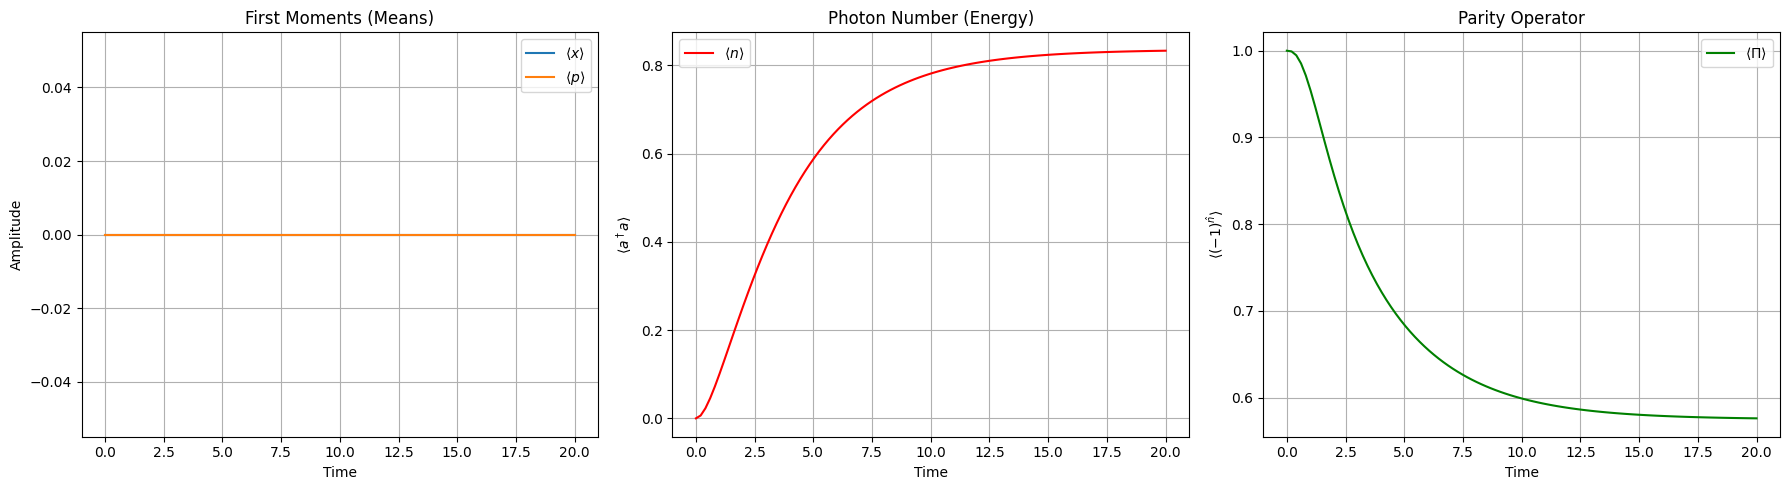

In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# --- 1. Parameters ---
# Identical to your JAX setup
G = .3 + .3j    # Two-photon drive strength
delta = .1       # Detuning
U = .1         # Kerr nonlinearity
gamma = 1      # Single-photon loss rate

# Simulation parameters
N = 100            # Hilbert space cutoff (must be high enough to capture squeezing)
t_start = 0.0
t_end = 20
steps = 100       # Higher resolution than the Euler step
tlist = np.linspace(t_start, t_end, steps)

# --- 2. Operators ---
a = qt.destroy(N)
n_op = a.dag() * a
x_op = (a + a.dag()) / np.sqrt(2) # Position quadrature
p_op = 1j * (a.dag() - a) / np.sqrt(2) # Momentum quadrature

# Parity operator defined as exp(i * pi * n)
# Equivalently, it is a diagonal matrix with entries (-1)^n
parity_op = (1j * np.pi * n_op).expm() 

# --- 3. Hamiltonian Construction ---
# H_detuning = delta * a^dag * a
H_det = -delta * n_op

# H_kerr = (U/2) * a^dag^2 * a^2 (Standard Kerr form)
H_kerr = 0.5 * U * a.dag()**2 * a**2

# H_drive = G * a^dag^2 + G* * a^2 (Two-photon drive)
# Note: In some conventions, this might be i(G a^dag^2 - G* a^2).
# Based on your JAX summation, it implies a direct Hermitian addition:
H_drive = (G/2 * a.dag()**2) + (np.conj(G)/2 * a**2)

# Total Hamiltonian
# To simulate the "Only G term" case, set delta=0 and U=0 here.
H = H_drive + H_det + H_kerr

# --- 4. Dissipation ---
# Single photon loss: sqrt(gamma) * a
c_ops = [np.sqrt(gamma) * a]

# --- 5. Initial State ---
# Vacuum state
psi0 = (qt.coherent(N, 2) + qt.coherent(N, -2)).unit()
psi0 = qt.basis(N, 0)

print(np.pi*qt.wigner(psi0, 0, 0))

# --- 6. Solve Master Equation ---
result = qt.mesolve(H, psi0, tlist, c_ops, e_ops=[x_op, p_op, n_op, parity_op], options={"store_final_state":True})

# --- 7. Plotting & Verification ---
means_x = result.expect[0]
means_p = result.expect[1]
means_n = result.expect[2]
means_parity = result.expect[3]

fig, ax = qt.plot_wigner(result.final_state, xvec=np.linspace(-5,5,100), yvec=np.linspace(-5,5,100), colorbar=True, cmap='RdBu_r')


# Add plot customizations (optional)
ax.set_title("Wigner function final")
plt.show()

print(f"{'Time':<8} | {'<X>':<10} | {'<P>':<10} | {'<n>':<10} | {'<Parity>':<10}")
print("-" * 65)
for i in range(0, len(tlist), 1): # Print every 10th step
    print(f"{tlist[i]:.4f}   | {means_x[i]:.6f}   | {means_p[i]:.6f}   | {means_n[i]:.6f}   | {means_parity[i]:.6f}")

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot Means
ax[0].plot(tlist, means_x, label=r'$\langle x \rangle$')
ax[0].plot(tlist, means_p, label=r'$\langle p \rangle$')
ax[0].set_title("First Moments (Means)")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Amplitude")
ax[0].legend()
ax[0].grid(True)

# Plot Photon Number
ax[1].plot(tlist, means_n, label=r'$\langle n \rangle$', color='r')
ax[1].set_title("Photon Number (Energy)")
ax[1].set_xlabel("Time")
ax[1].set_ylabel(r"$\langle a^\dagger a \rangle$")
ax[1].legend()
ax[1].grid(True)

# Plot Parity
ax[2].plot(tlist, means_parity, label=r'$\langle \Pi \rangle$', color='g')
ax[2].set_title("Parity Operator")
ax[2].set_xlabel("Time")
ax[2].set_ylabel(r"$\langle (-1)^{\hat{n}} \rangle$")
ax[2].legend()
ax[2].grid(True)

plt.tight_layout()
plt.show()